## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


--> ml20j22l

Your full name:

--> Jiachen Liu

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [12]:
import os
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Define your own class LoadFromFolder
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
         
        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

In [13]:
def __len__(self):
    # Return the previously computed number of images
    return len(self.total_imgs)

In [14]:
def __getitem__(self, idx):
    img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
     
    # Use PIL for image loading
    image = Image.open(img_loc).convert("RGB")
    # Apply the transformations
    tensor_image = self.transform(image)
    return tensor_image

In [17]:
from torchvision.datasets import ImageFolder
train_set_od = ImageFolder(
    root="C:/Users/lenovo/Desktop/AI/comp5623m-2022/train_set/train_set", 
    transform=transforms.ToTensor()
)
validation_set , train_set = train_test_split(train_set_od, test_size=0.75) 

train_loader = DataLoader(
    train_set,
    batch_size = 64,
    shuffle = True,
    num_workers = 1
)
validation_loader = DataLoader(
    validation_set,
    batch_size = 64,
    shuffle = True,
    num_workers = 1
)

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [18]:
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

In [24]:
# define a Model class
net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=5),    # no padding, stride=1, dilation=1 by default
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*13*13,64),     # with 32x32 input, the feature map size reduces to 13x13 with 16 channels.
    nn.ReLU(),
    nn.Linear(64,30)
)

for param in net.parameters():
    print(param.shape)

torch.Size([8, 3, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([64, 2704])
torch.Size([64])
torch.Size([30, 64])
torch.Size([30])


### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [25]:
import torch.optim as optim
nepochs = 50
results_path = 'C:/Users/lenovo/Desktop/AI/train_set.pt'
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

batch_train = next(iter(train_loader))

batch_va = next(iter(validation_loader))

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in batch_train:
        inputs, labels = batch_train
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(validation_loader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  3.408 training accuracy:  3.1%  test loss:  3.404 test accuracy:  3.0%
epoch: 1 training loss:  3.408 training accuracy:  4.7%  test loss:  3.404 test accuracy:  3.1%
epoch: 2 training loss:  3.406 training accuracy:  6.2%  test loss:  3.404 test accuracy:  3.1%
epoch: 3 training loss:  3.404 training accuracy:  6.2%  test loss:  3.404 test accuracy:  3.2%
epoch: 4 training loss:  3.402 training accuracy:  6.2%  test loss:  3.404 test accuracy:  3.2%
epoch: 5 training loss:  3.400 training accuracy:  6.2%  test loss:  3.404 test accuracy:  3.3%
epoch: 6 training loss:  3.397 training accuracy:  6.2%  test loss:  3.404 test accuracy:  3.1%
epoch: 7 training loss:  3.395 training accuracy:  6.2%  test loss:  3.404 test accuracy:  3.2%
epoch: 8 training loss:  3.393 training accuracy:  6.2%  test loss:  3.404 test accuracy:  3.2%
epoch: 9 training loss:  3.390 training accuracy:  6.2%  test loss:  3.404 test accuracy:  3.2%
epoch: 10 training loss:  3.388 training

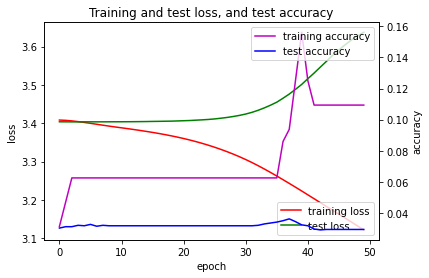

In [26]:
results_path = 'C:/Users/lenovo/Desktop/AI/train_set.pt'
data = torch.load(results_path)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc1.jpg")
plt.show()



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [27]:
nepochs = 50
results_path = 'C:/Users/lenovo/Desktop/AI/CW1_1.21.pt'
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(validation_loader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  3.414 training accuracy:  4.4%  test loss:  3.400 test accuracy:  5.0%
epoch: 1 training loss:  3.396 training accuracy:  5.2%  test loss:  3.394 test accuracy:  5.5%
epoch: 2 training loss:  3.388 training accuracy:  5.8%  test loss:  3.386 test accuracy:  5.7%
epoch: 3 training loss:  3.372 training accuracy:  7.0%  test loss:  3.362 test accuracy:  7.0%
epoch: 4 training loss:  3.330 training accuracy:  8.1%  test loss:  3.294 test accuracy:  9.4%
epoch: 5 training loss:  3.227 training accuracy:  10.0%  test loss:  3.159 test accuracy:  11.1%
epoch: 6 training loss:  3.123 training accuracy:  12.2%  test loss:  3.095 test accuracy:  13.6%
epoch: 7 training loss:  3.050 training accuracy:  14.4%  test loss:  3.031 test accuracy:  14.7%
epoch: 8 training loss:  2.998 training accuracy:  15.8%  test loss:  3.007 test accuracy:  15.1%
epoch: 9 training loss:  2.960 training accuracy:  16.7%  test loss:  2.965 test accuracy:  17.2%
epoch: 10 training loss:  2.92

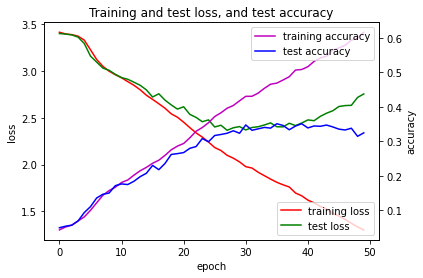

In [28]:
results_path = 'C:/Users/lenovo/Desktop/AI/CW1_1.21.pt'
data = torch.load(results_path)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc2.jpg")
plt.show()


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



In [29]:
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5)
])

train_set_od = ImageFolder(
    root="C:/Users/lenovo/Desktop/AI/comp5623m-2022/train_set/train_set", 
    transform=trnsfrm
)
validation_set , train_set = train_test_split(train_set_od, test_size=0.75) 

train_loader = DataLoader(
    train_set,
    batch_size = 64,
    shuffle = True,
    num_workers = 1
)
validation_loader = DataLoader(
    validation_set,
    batch_size = 64,
    shuffle = True,
    num_workers = 1
)

In [30]:
model_122a = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=5),    # no padding, stride=1, dilation=1 by default
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*13*13,64),     # with 32x32 input, the feature map size reduces to 13x13 with 16 channels.
    nn.ReLU(),
    nn.Linear(64,30)
)

for param in model_122a.parameters():
    print(param.shape)

torch.Size([8, 3, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([64, 2704])
torch.Size([64])
torch.Size([30, 64])
torch.Size([30])


In [31]:
nepochs = 50
results_path = 'C:/Users/lenovo/Desktop/AI/CW1_1.22a.pt'
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_122a.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = model_122a(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(validation_loader, model_122a)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

# save network parameters, losses and accuracy
torch.save({"state_dict": model_122a.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  3.404 training accuracy:  3.3%  test loss:  3.402 test accuracy:  3.6%
epoch: 1 training loss:  3.401 training accuracy:  4.5%  test loss:  3.400 test accuracy:  3.7%
epoch: 2 training loss:  3.399 training accuracy:  4.4%  test loss:  3.399 test accuracy:  3.9%
epoch: 3 training loss:  3.397 training accuracy:  4.1%  test loss:  3.396 test accuracy:  4.1%
epoch: 4 training loss:  3.391 training accuracy:  4.8%  test loss:  3.390 test accuracy:  4.9%
epoch: 5 training loss:  3.380 training accuracy:  5.3%  test loss:  3.377 test accuracy:  5.5%
epoch: 6 training loss:  3.353 training accuracy:  7.5%  test loss:  3.342 test accuracy:  8.9%
epoch: 7 training loss:  3.278 training accuracy:  9.8%  test loss:  3.261 test accuracy:  8.3%
epoch: 8 training loss:  3.197 training accuracy:  10.8%  test loss:  3.199 test accuracy:  10.2%
epoch: 9 training loss:  3.141 training accuracy:  12.3%  test loss:  3.152 test accuracy:  11.2%
epoch: 10 training loss:  3.107 trai

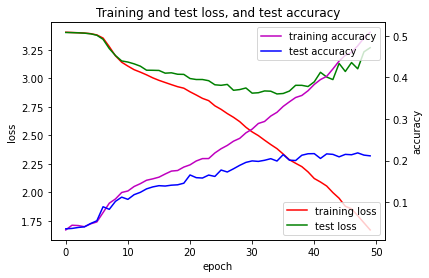

In [32]:
results_path = 'C:/Users/lenovo/Desktop/AI/CW1_1.22a.pt'
data = torch.load(results_path)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc3.jpg")
plt.show()

In [33]:
model_122b = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=16 ,kernel_size=3,padding = 1),    # no padding, stride=1, dilation=1 by default
    nn.BatchNorm2d(16), 
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16,out_channels=64,kernel_size=3,padding = 1),
    nn.BatchNorm2d(64),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding = 1),
    nn.BatchNorm2d(128),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(128*8*8,64),     # with 32x32 input, the feature map size reduces to 8x8 with 128 channels.
    nn.ReLU(),
    nn.Linear(64,30)
)

In [35]:
nepochs = 50
results_path = 'C:/Users/lenovo/Desktop/AI/CW1_1.22b.pt'
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_122b.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = model_122b(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(validation_loader, model_122b)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

# save network parameters, losses and accuracy
torch.save({"state_dict": model_122b.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  2.606 training accuracy:  25.0%  test loss:  2.669 test accuracy:  23.4%
epoch: 1 training loss:  2.519 training accuracy:  27.2%  test loss:  2.608 test accuracy:  25.7%
epoch: 2 training loss:  2.442 training accuracy:  29.3%  test loss:  2.545 test accuracy:  26.7%
epoch: 3 training loss:  2.369 training accuracy:  30.7%  test loss:  2.577 test accuracy:  26.5%
epoch: 4 training loss:  2.310 training accuracy:  32.8%  test loss:  2.517 test accuracy:  28.0%
epoch: 5 training loss:  2.251 training accuracy:  34.5%  test loss:  2.541 test accuracy:  27.7%
epoch: 6 training loss:  2.191 training accuracy:  36.0%  test loss:  2.489 test accuracy:  28.5%
epoch: 7 training loss:  2.157 training accuracy:  37.8%  test loss:  2.457 test accuracy:  29.4%
epoch: 8 training loss:  2.089 training accuracy:  39.2%  test loss:  2.458 test accuracy:  30.5%
epoch: 9 training loss:  2.044 training accuracy:  40.5%  test loss:  2.457 test accuracy:  28.8%
epoch: 10 training l

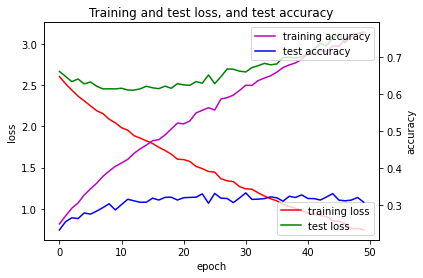

In [36]:
results_path = 'C:/Users/lenovo/Desktop/AI/CW1_1.22b.pt'
data = torch.load(results_path)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc4.jpg")
plt.show()


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

(-0.5, 431.5, 287.5, -0.5)

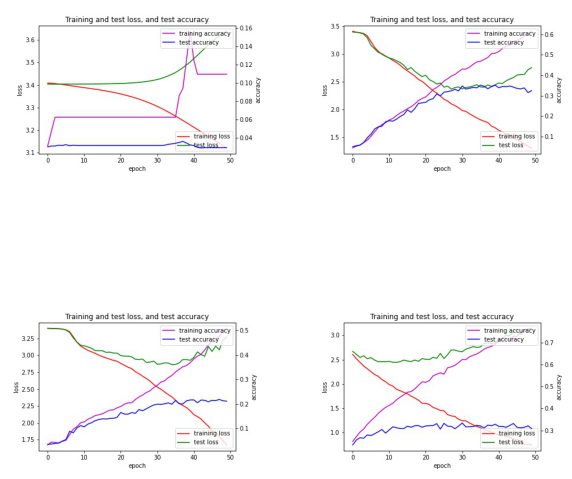

In [37]:
im1=plt.imread('roc1.jpg')
im2=plt.imread('roc2.jpg')
im3=plt.imread('roc3.jpg')
im4=plt.imread('roc4.jpg')

plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
plt.imshow(im1)
ax.axis('off')

ax = plt.subplot(2,2,2)
plt.imshow(im2)
ax.axis('off')

ax = plt.subplot(2,2,3)
plt.imshow(im3)
ax.axis('off')

ax = plt.subplot(2,2,4)
plt.imshow(im4)
ax.axis('off')

Explain what can be seen in the graphs.

--> Double click here to respond


### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



In [38]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)

Confusion matrix
[[232   1   1  14   0   0   3   4  15   0   2   0   9   0   0   1   1   1
    6   0   7   2   7  17   0   0   3   2   4   1]
 [  1 277   5   0   0   3   4   3   2   0   1   4   2   4   3  10   1   0
    0   1   1   6   1   1   2  10   1   2   7   1]
 [  2   1 298   0   2   0   0   1   0   0   3   1   0   3   0   2   0   1
    4   1   4   1   0   0   2   2   1   0   4   1]
 [  3   0   0 291   0   0   0   1  14   0   0   1   4   0   0   0   1   0
    2   0   0   0   3   5   0   0   1   0   2   2]
 [  0   0   7   0 317   0   0   0   1   0   0   0   1   1   0   2   1   0
    0   0   0   0   2   0   2   0   0   1   4   1]
 [  0  13   9   3   3 224   2   4   1   1   0   8   3   1   3   6   6   4
    1   0   4   4   9   1   4   1   1   7   9   7]
 [  4   1   1   8   1   0 249   1  12   0   0   4   4   0   1   2   4   4
   11   1   4   2   6   4   2   2   0   3   8   6]
 [  1   3   6   1   1   1   1 262   0   0   1   1   8   2   2   5   5   2
    0   0   6   3   2  11   1   3 

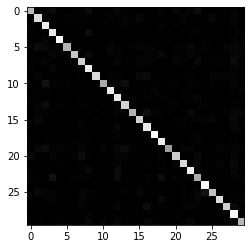

In [39]:
classes=np.arange(30)
#classes = ["baboon", "banana", "bee", "bison", "butterfly", "candle", "cardigan", "chihuahua", "elephant", "espresso","fly","goldfish","goose","grasshopper","hourglass","icecream","ipod","jellyfish","koala","ladybug","lion","mushroom","penguin","pig","pizza","pretzel","redpanda","refrigerator","sombrero","umbrella"]
d = torch.load('C:/Users/lenovo/Desktop/AI/CW1_1.22b.pt')
# now load the parameter state into the current model (make sure this is the right model).
model_122b.load_state_dict(d["state_dict"])

# initialise confusion matrix
nclasses = classes.shape[0]
cnfm = np.zeros((nclasses,nclasses),dtype=int)

# work without gradient computation since we are testing (i.e. no optimisation)
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model_122b(images)
        
        # find the class with the highest output.
        # note that the outputs are confidence values since we didn't need to apply softmax in our network
        # (nn.crossentropyloss takes raw condifence values and does its own softmax)   
        _, predicted = torch.max(outputs, 1)    
       
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm[labels[i].item(),predicted[i].item()] += 1
              
print("Confusion matrix")
print(cnfm)

# show confusion matrix as a grey-level image
plt.imshow(cnfm, cmap='gray')

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm) :.1%}")
r = recalls(cnfm)
p = precisions(cnfm)
for i in range(nclasses):
    print(f"Class {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")


What conclusions can be drawn from the confusion matrices?

---> Double click to respond here



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [40]:
import pandas as pd

In [106]:
class ImageLoaderI(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        #Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
            x = x.convert('RGB')  # To deal with some grayscale images in the data
        except:
            pass
        y = torch.tensor(int(self.df['class'][index]))

        #path1 = self.df['path'][index]

        if self.transform:
            x = self.transform(x)

        return x, y

In [107]:
# load images to test_loader
paths_test, classes_test = [], []
root_dir = "C:/Users/lenovo/Desktop/AI/comp5623m-2022/test_set/test_set"
for entry in os.scandir(root_dir):
    if (entry.is_file()):
        paths_test.append(entry.path)
        classes_test.append(i)
data = {
    'path': paths_test,
    'class': classes_test
}
data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) #Shuffles the data

# See what the dataframe now contains
print("Found", len(data_df), "images.")

Found 1500 images.


In [108]:
data_df

,path,class
0,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29
1,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29
2,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29
3,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29
4,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29
...,...,...
1495,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29
1496,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29
1497,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29
1498,C:/Users/lenovo/Desktop/AI/comp5623m-2022/test...,29


In [132]:
import torch

dataset_test = ImageLoaderI(
    df=data_df,
    transform=transforms.ToTensor(),
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=True,
    num_workers=1
)

In [ ]:
print("len(test_loader)", len(test_loader))
print("len(test_set)",len(dataset_test))

In [ ]:
def predict_test(net,loader):
    net.eval()
    pre = []
    paths = []
    with torch.no_grad():
        for data in loader:
            img,_, path = data
            outputs = net(img)

            _,predicted = torch.max(outputs.data,1)
            pre.append(predicted)
            paths.append(path)
    return pre,paths

pre,pathpath = predict_test(model_122b,test_loader)

In [ ]:
predict_class = []
predict_path = []
s = 0
for k in range(23):
    for h in range(64):
        predict_class.append(pre[k][h].cpu().numpy())
        predict_path.append(pathpath[k][h])
for h in range(28):
    predict_class.append(pre[23][h].cpu().numpy())
    predict_path.append(pathpath[23][h])
predict_class = list(predict_class)

# only leave number in predict_class[]
for i in range(len(predict_class)):
    predict_class[i] = int(predict_class[i])

# only leave file name in predict_path1[], without path
predict_path1 = []
for i in range(len(predict_path)):
    predict_path1.append(predict_path[i][38:]) # predict_path contains paths and file name. [38:] means just get name of images

# put file name and corresponding prediction into the same row, preparing for writing csv
final_outputs = [[] for i in range(1500)]
for i in range(1500):
    final_outputs[i].append(predict_path1[i])
    final_outputs[i].append(predict_class[i])


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [ ]:
# Save all test predictions and files name into csv file
import csv
results_file = open('ml20j22l.csv', 'w', newline='')
csv_writer = csv.writer(results_file)
for row in final_outputs:
    csv_writer.writerow(row)
results_file.close()



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [110]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\lenovo/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\lenovo/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [111]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [112]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [113]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [114]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    filters = model.features[layer_idx].weight.data
    return filters

In [115]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [116]:
filters[0].shape

torch.Size([64, 3, 11, 11])

In [117]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



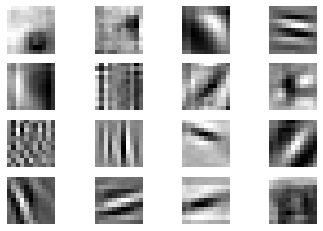

In [118]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [119]:
im = Image.open('C:/Users/lenovo/Desktop/AI/man_bike.JPEG')

Run the code cell below to apply the image transformation expected by the model.

In [120]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [121]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """

    feature_maps=[]
 
    img_feature1=model.features[2](model.features[1](model.features[0](image)))
    feature_maps.append(img_feature1)
    
    img_feature2=model.features[5](model.features[4](model.features[3](img_feature1)))
    feature_maps.append(img_feature2)
    
    img_feature3=model.features[11](model.features[10](model.features[9](model.features[8](model.features[7](model.features[6](img_feature2))))))
    feature_maps.append(img_feature3)
    
    
    return feature_maps
    

In [122]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

In [123]:
len(feature_maps)
list(feature_maps[1].shape)

[1, 192, 15, 15]

For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [124]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

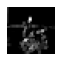

In [126]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[0].detach().numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()

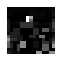

In [127]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[1].detach().numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()

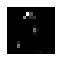

In [128]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[2].detach().numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


--> Double click here to respond

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.

--> The filter operate on the input data, and give activation accordingly. The values to the filter (the weights) are learned to activate on certain feature in the input data.

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.

--> The values of the feature map become increasingly sparse as the depth of the network increases.


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [ ]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [ ]:
model = alexnet(pretrained=True)

In [ ]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [1]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE

    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    
    # TO COMPLETE
    # return heatmap

In [ ]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [ ]:
# TO COMPLETE

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

In [ ]:
# TO COMPLETE

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

In [ ]:
# TO COMPLETE

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

--> Double click to respond here

### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
